# Population Structure

## The data set

The data for this exercise comes from the Simons Genome Diversity Project (SGDP), a large-scale whole-genome sequencing effort that provides high-coverage genomes from diverse human populations around the world. The SGDP was designed to capture a broad sweep of human genetic diversity, sampling individuals from populations that span the major continental groups and represent a wide range of demographic histories and geographic locations.

We will work with a subset of the SGDP consisting of individuals from 22 populations: Ju/'hoan North (Namibia), Esan (Nigeria), Luhya (Kenya), Mandenka (West Africa), Yoruba (Nigeria), and Luo (Kenya) representing sub-Saharan Africa; Miao, Naxi, and Han (China), Japanese, Atayal and Ami (Taiwan), Cambodian, Korean, and Kinh (Vietnam) representing East and Southeast Asia; and Bulgarian, Druze, English, Georgian, Hungarian, Icelandic, and Iranian representing West Eurasia. This selection gives us representatives of three major continental groups — Africa, East Asia, and West Eurasia — with enough populations in each group to observe both between-group and within-group genetic structure.

Rather than analyzing the entire genome, we focus on a 10 Mb region of chromosome 2 (positions 135–145 Mb). Working with a smaller genomic region keeps computation manageable for the exercise while still providing enough variant sites to resolve population structure at the continental level. The data is provided in VCF format.

The VCF file (`chr2_135_145_flt.vcf.gz`) is already in your folder along with a CSV file with information about the samples (`sample_infos_accessionnb.csv`).


Import the libraries needed for this exercise:

In [50]:
import os, shutil, numpy, pandas, re
import sgkit, bio2zarr.vcf, sklearn.decomposition
import cartopy.crs, cartopy.feature
import seaborn, matplotlib.pyplot as plt

And a bit to make the plots look nicer in vscode:

In [ ]:
%config InlineBackend.figure_format = 'svg'
from vscodenb import set_vscode_theme, vscode_theme
set_vscode_theme()
seaborn.set_palette('tab10')

Now read the metadata information into a data frame:

In [2]:
info = pandas.read_csv("sample_infos_accessionnb.csv", sep=";")
info.set_index('ENA-RUN', inplace=True)
info.head()

,ID,population,region,country,latitude,longitude,Sex,Illumina ID
ENA-RUN,,,,,,,,
ERR1019075,ERS1042176,Ju_hoan_North,Africa,Namibia,-18.9,21.5,male,LP6005441-DNA_B11
ERR1019076,ERS1042177,Ju_hoan_North,Africa,Namibia,-18.9,21.5,male,LP6005441-DNA_A11
ERR1025622,ERS1042248,Esan,Africa,Nigeria,6.5,6.0,female,LP6005442-DNA_B10
ERR1025639,ERS1042265,Luhya,Africa,Kenya,1.3,36.8,male,LP6005442-DNA_E11
ERR1025640,ERS1042266,Mandenka,Africa,Senegal,12.0,-12.0,male,LP6005441-DNA_E07


Lets draw a map showing the location of each sampled population:

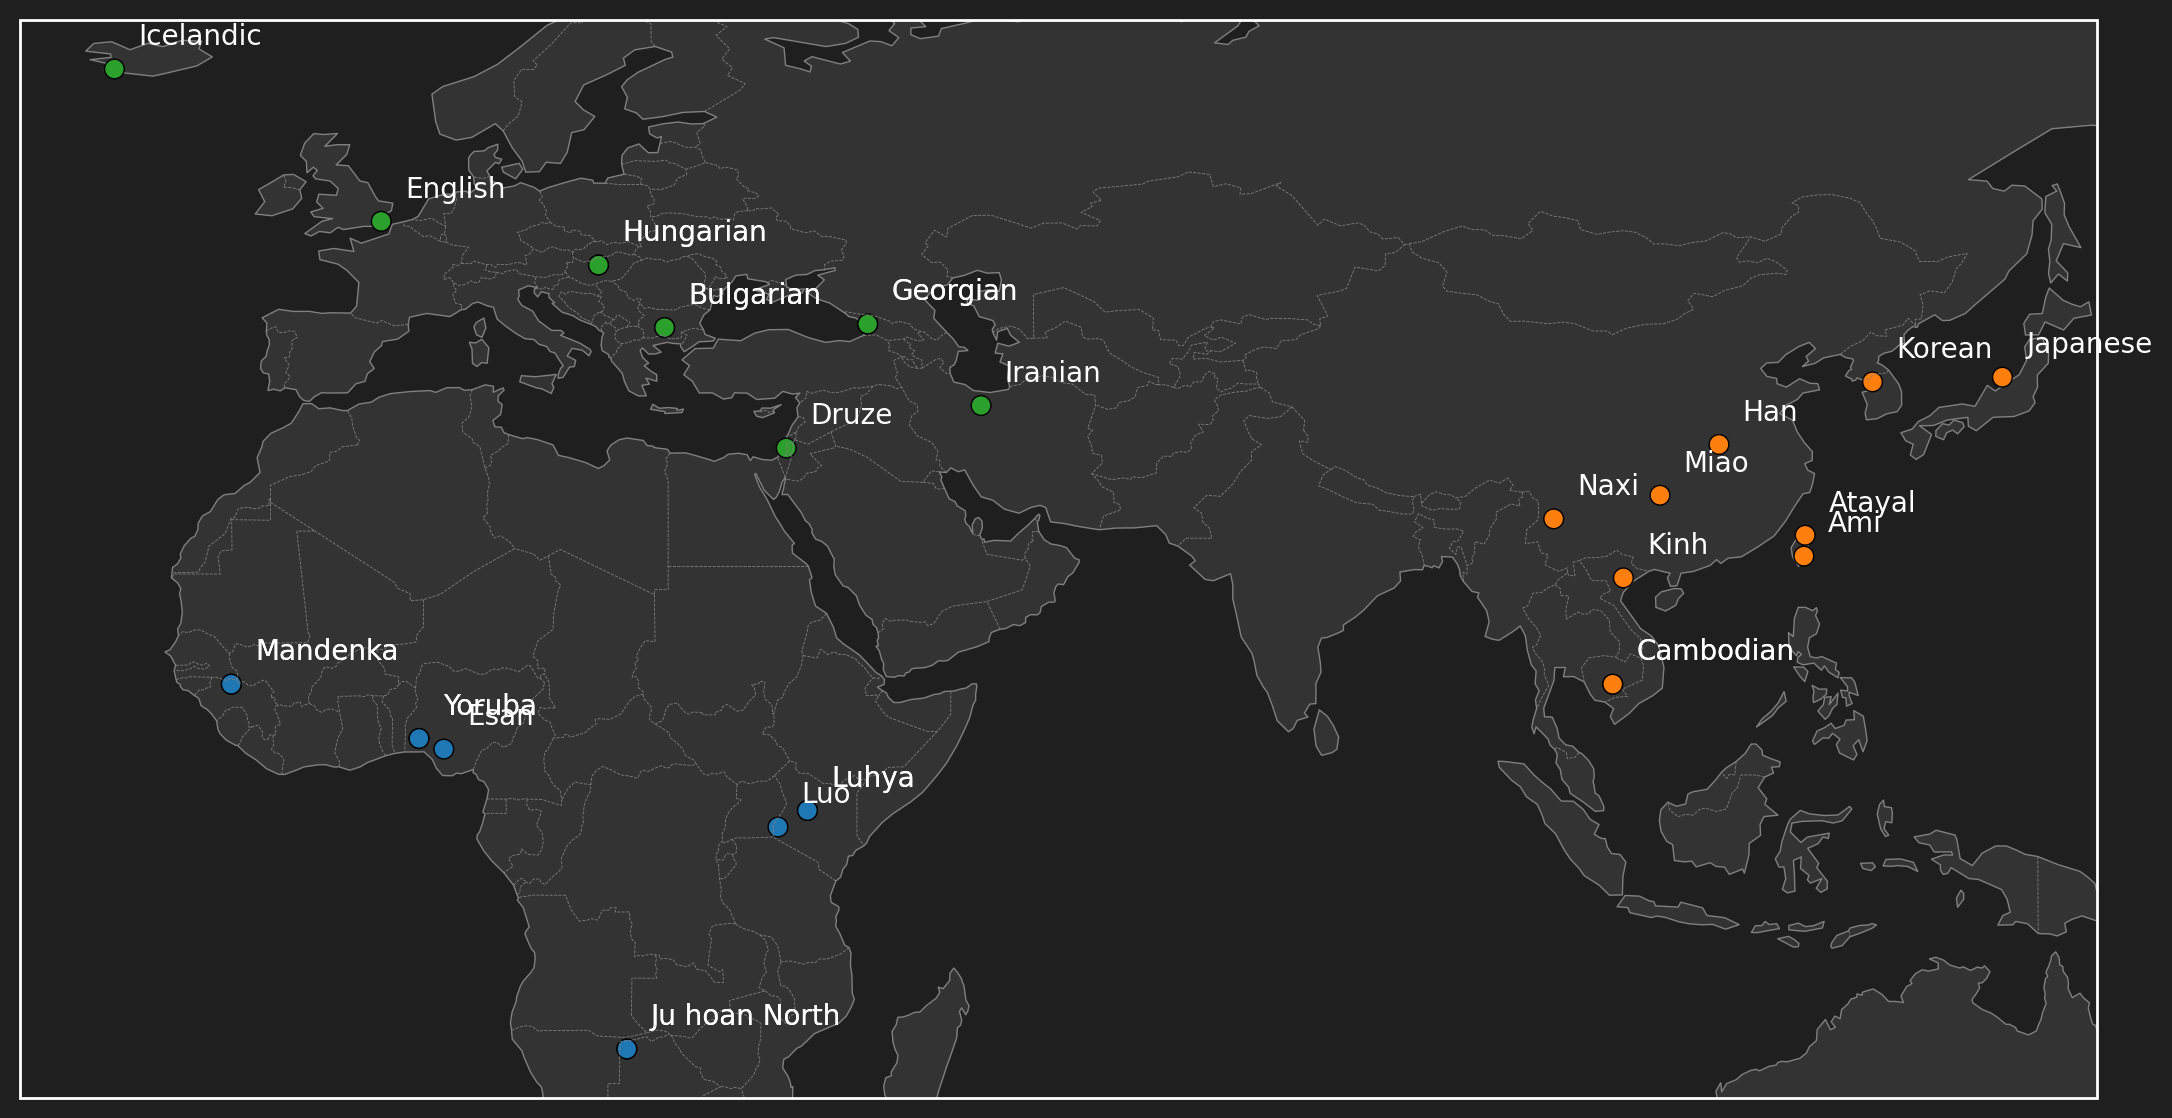

In [3]:
fig, ax = plt.subplots(figsize=(14, 7), subplot_kw={'projection': cartopy.crs.PlateCarree()})

ax.add_feature(cartopy.feature.LAND, facecolor="#333333", edgecolor="gray", linewidth=0.5)
ax.add_feature(cartopy.feature.BORDERS, linewidth=0.3, linestyle="--", edgecolor="gray")

seaborn.scatterplot(x='longitude', y='latitude', hue='region', data=info, ax=ax, s=50, 
                edgecolor="black", linewidth=0.5, palette='tab10', legend=False)

for pop, lat, lon in info[['population', 'latitude', 'longitude']].itertuples(index=False):
    ax.text(lon + 2, lat + 1.5, pop.replace("_", " "), fontsize=10, color='white',
                 transform=cartopy.crs.PlateCarree(), ha="left", va="bottom")

We will use the [sgkit](https://sgkit-dev.github.io/sgkit/latest/) library for this exercise. sgkit needs data to be in the [zarr format](https://zarr.readthedocs.io/en/stable/), so the first thing we need to do is convert our VCF file to Zarr format using the [bio2zarr](https://sgkit-dev.github.io/bio2zarr/intro.html) library:

In [4]:
vcf_path, zarr_path = "chr2_135_145_flt.vcf.gz", "zarr_data"
if os.path.exists(zarr_path): shutil.rmtree(zarr_path)
bio2zarr.vcf.convert([vcf_path], zarr_path)

[W::bcf_hdr_check_sanity] GL should be declared as Number=G
Total records unknown, cannot show progress; reindex VCFs with bcftools index to fix


Now you have a data folder called `zarr_data` in your folder that you can load using `sgkit`:

In [6]:
ds = sgkit.load_dataset(zarr_path)

#### Have a look at the dataset (you can unfold the "Data variables"). How is it structured and what it contain? What are the advantages of the Zarr format?

In [7]:
ds

<xarray.Dataset> Size: 39MB
Dimensions:                 (variants: 49868, samples: 27, FORMAT_GL_dim: 3,
                             ploidy: 2, contigs: 1, filters: 13,
                             region_index_values: 50, region_index_fields: 6,
                             alt_alleles: 1, alleles: 2)
Dimensions without coordinates: variants, samples, FORMAT_GL_dim, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields, alt_alleles, alleles
Data variables: (12/48)
    call_GL                 (variants, samples, FORMAT_GL_dim) float32 16MB dask.array<chunksize=(1000, 27, 3), meta=np.ndarray>
    call_GOF                (variants, samples) float32 5MB dask.array<chunksize=(1000, 27), meta=np.ndarray>
    call_GQ                 (variants, samples) int8 1MB dask.array<chunksize=(1000, 27), meta=np.ndarray>
    call_NR                 (variants, samples) int8 1MB dask.array<chunksize=(1000, 27), meta=np.ndarray>
    call_NV                 (variants, samples) int8 1MB dask.array<chunksize=(1000, 27), meta=np.ndarray>
    call_genotype           (variants, samples, ploidy) int8 3MB dask.array<chunksize=(1000, 27, 2), meta=np.ndarray>
    ...                      ...
    variant_filter          (variants, filters) bool 648kB dask.array<chunksize=(1000, 13), meta=np.ndarray>
    variant_id              (variants) object 399kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask         (variants) bool 50kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length          (variants) int8 50kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position        (variants) int32 199kB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality         (variants) float32 199kB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    source:                bio2zarr-0.1.7
    vcf_meta_information:  [['fileformat', 'VCFv4.0'], ['fileDate', '2018-02-...
    vcf_zarr_version:      0.4

The `sizes` attribute is a dictionary with the sizes/counts of elements in the dataset. 

In [ ]:
ds.sizes

Frozen({'variants': 49868, 'samples': 27, 'FORMAT_GL_dim': 3, 'ploidy': 2, 'contigs': 1, 'filters': 13, 'region_index_values': 50, 'region_index_fields': 6, 'alt_alleles': 1, 'alleles': 2})


Extract the number of variants and samples:

In [ ]:
n_variants = ds.sizes["variants"]
n_samples = ds.sizes["samples"]

You can access the each dataset variable as with a dictionary:

In [16]:
ds["call_genotype"]

<xarray.DataArray 'call_genotype' (variants: 49868, samples: 27, ploidy: 2)> Size: 3MB
dask.array<open_dataset-call_genotype, shape=(49868, 27, 2), dtype=int8, chunksize=(1000, 27, 2), chunktype=numpy.ndarray>
Dimensions without coordinates: variants, samples, ploidy
Attributes:
    description:

Use the `values` attribute to get the actual values as a numpy array:

In [17]:
ds["call_genotype"].values

array([[[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 1],
        [0, 1],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 1],
        [1, 1],
        [0, 1],
        ...,
        [0, 1],
        [0, 1],
        [1, 1]],

       ...,

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=int8)

In [21]:
samples = ds["sample_id"].values

Extract genotype matrix and identify variants with no missing data in any sample:

In [22]:
gt = ds["call_genotype"].values
is_called = numpy.all(gt >= 0, axis=(1, 2))

Compute alternative allele count per individual (dosage: 0, 1, or 2) for the sites with no missing data:

In [23]:
gn_filt = gt[is_called].sum(axis=2)  # sum over ploidy dimension

## Principal Component Analysis (PCA)

Principal component analysis (PCA) is one of the most widely used methods for exploring population structure in genomic data. The basic idea is dimensionality reduction: a genotype matrix with thousands of variant sites and dozens (or hundreds) of individuals lives in a very high-dimensional space, but the major axes of variation in that space often correspond to meaningful biological signals — most prominently, geographic and demographic history.
In practice, we arrange the data as a matrix where each row is an individual and each column is a SNP, with entries coded as 0, 1, or 2 copies of the alternative allele. PCA finds the linear combinations of SNPs (the principal components) that capture the most variance across individuals. The first principal component (PC1) captures the single direction of greatest variation, PC2 the next-greatest orthogonal direction, and so on.
For human genomic data, the top principal components typically reflect continental-level ancestry differences. In a data set like ours, with African, East Asian, and West Eurasian populations, we can expect PC1 and PC2 to separate the three continental groups, while lower-ranked components may reveal finer-scale structure within continents. This pattern arises because genetic differentiation between continental groups — shaped by the out-of-Africa dispersal and subsequent drift — accounts for a large fraction of the total variance in allele frequencies.

We will use `sgkit` for reading VCF files and LD pruning and `scikit-learn` for PCA. 

In [24]:
# The total number of PCs is min(n_samples - 1, n_snps)
n_pcs = min(gn_filt.shape[1] - 1, gn_filt.shape[0])
print(f"Number of PCs to compute: {n_pcs}")

# Run PCA using scikit-learn
# Transpose: PCA expects samples as rows, features (SNPs) as columns
pca = sklearn.decomposition.PCA(n_components=n_pcs)
eigenvectors = pca.fit_transform(gn_filt.T)  # shape: (n_samples, n_pcs)

Number of PCs to compute: 26


In [25]:
print(f"PCA summary:")
print(f"  Number of samples: {eigenvectors.shape[0]}")
print(f"  Number of PCs: {eigenvectors.shape[1]}")
print(f"  Eigenvalues (first 5): {pca.explained_variance_[:5]}")
print(f"  Variance explained % (first 5): {pca.explained_variance_ratio_[:5] * 100}")

PCA summary:
  Number of samples: 27
  Number of PCs: 26
  Eigenvalues (first 5): [1245.11042422  740.09948411  628.27935337  450.67588756  448.64556188]
  Variance explained % (first 5): [14.03412112  8.34194751  7.08157957  5.07974222  5.05685763]


#### How many individuals and SNPs does this dataset have? What is an eigenvector and an eigenvalue?

In [28]:
# Build a DataFrame of eigenvectors with metadata
pc_cols = [f"PC{i+1}" for i in range(n_pcs)]
df_pca = pandas.DataFrame(eigenvectors, columns=pc_cols)
df_pca.set_index(samples, inplace=True)
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
ERR1019039,-18.690944,4.623870,-26.388924,0.623133,23.368549,-6.895789,0.943614,-1.604482,24.827400,-5.432288,...,-7.377478,-9.208940,1.085020,-35.944449,-13.688892,23.334036,-33.636806,-11.446296,0.219044,-2.592422
ERR1019060,-25.353036,19.570746,-44.371686,10.712055,3.444744,-7.494783,-17.210074,8.397532,-1.820032,9.935562,...,-12.709202,3.819910,1.250815,26.599219,-7.244852,-33.532279,-18.313823,5.319316,5.161052,-23.700147
ERR1019074,-15.229470,8.969083,-32.059639,7.782029,-11.898575,-19.219315,-52.370693,-23.968372,6.828568,23.973360,...,-7.115231,-2.188208,23.527063,-11.180934,3.919307,6.010615,16.145222,0.991383,-10.653957,5.832283
ERR1019075,71.205391,72.714818,18.189021,-1.578295,2.366531,7.292807,-4.252009,-5.586110,-5.558817,1.814078,...,12.358749,-8.052115,-2.732021,-4.490093,4.365424,3.041697,-16.466522,38.950039,-4.484632,3.953240
ERR1019076,68.931671,75.330568,17.530993,-3.601108,3.587117,2.304235,-0.042917,2.148330,5.444354,-0.322592,...,-11.949455,5.796159,2.696323,4.919852,-2.491739,-1.594199,14.455003,-39.576559,4.178414,-2.496940


Merge with metadata:

In [29]:
df_pca = df_pca.merge(info, left_index=True, right_index=True)
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC25,PC26,ID,population,region,country,latitude,longitude,Sex,Illumina ID
ERR1019039,-18.690944,4.623870,-26.388924,0.623133,23.368549,-6.895789,0.943614,-1.604482,24.827400,-5.432288,...,0.219044,-2.592422,ERS1042141,Naxi,EastAsia,China,26.0,100.0,male,LP6005441-DNA_A09
ERR1019060,-25.353036,19.570746,-44.371686,10.712055,3.444744,-7.494783,-17.210074,8.397532,-1.820032,9.935562,...,5.161052,-23.700147,ERS1042124,Miao,EastAsia,China,28.0,109.0,male,LP6005441-DNA_C08
ERR1019074,-15.229470,8.969083,-32.059639,7.782029,-11.898575,-19.219315,-52.370693,-23.968372,6.828568,23.973360,...,-10.653957,5.832283,ERS1042175,Japanese,EastAsia,Japan,38.0,138.0,female,LP6005441-DNA_D06
ERR1019075,71.205391,72.714818,18.189021,-1.578295,2.366531,7.292807,-4.252009,-5.586110,-5.558817,1.814078,...,-4.484632,3.953240,ERS1042176,Ju_hoan_North,Africa,Namibia,-18.9,21.5,male,LP6005441-DNA_B11
ERR1019076,68.931671,75.330568,17.530993,-3.601108,3.587117,2.304235,-0.042917,2.148330,5.444354,-0.322592,...,4.178414,-2.496940,ERS1042177,Ju_hoan_North,Africa,Namibia,-18.9,21.5,male,LP6005441-DNA_A11


Let's first look at how much of the variance of the data is explained by each eigenvector:

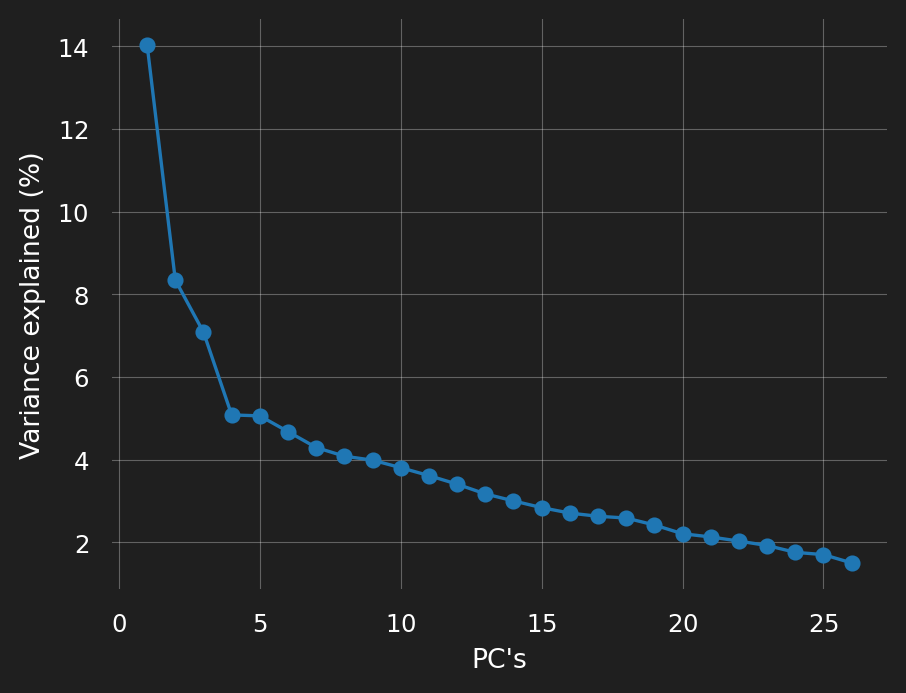

In [31]:
# Variance proportion (scree plot)
pca_percent = pca.explained_variance_ratio_ * 100

#fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(range(1, len(pca_percent) + 1), pca_percent, "o-")
plt.xlabel("PC's")
plt.ylabel("Variance explained (%)")
plt.show()

#### How many PCs do we need in order to explain 50% of the variance of the data? Can you make a cumulative plot of the variance explained per PC?

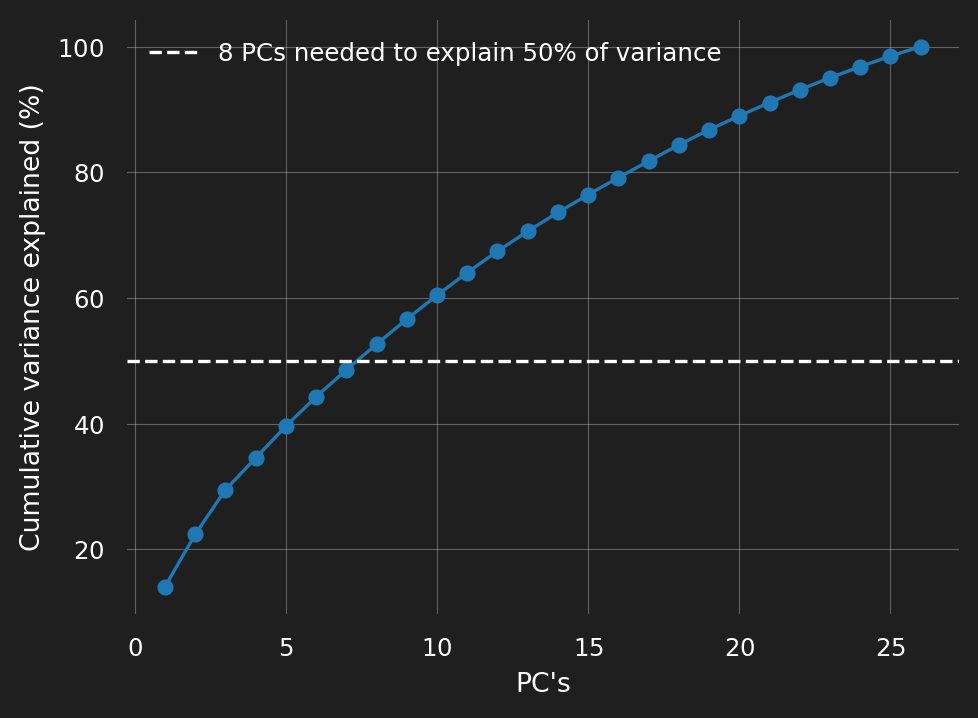

In [ ]:
# Hint for Q.2: cumulative variance plot
cumulative = numpy.cumsum(pca_percent)
n_for_50 = numpy.argmax(cumulative >= 50) + 1

plt.plot(range(1, len(cumulative) + 1), cumulative, "o-")
plt.axhline(y=50, linestyle="--", label=f"{n_for_50} PCs needed to explain 50%")
plt.xlabel("PC's")
plt.ylabel("Cumulative variance explained (%)")
plt.legend()
plt.show()

Now, let's plot the two first PCs and color the datapoints by the origin of each individual sample.

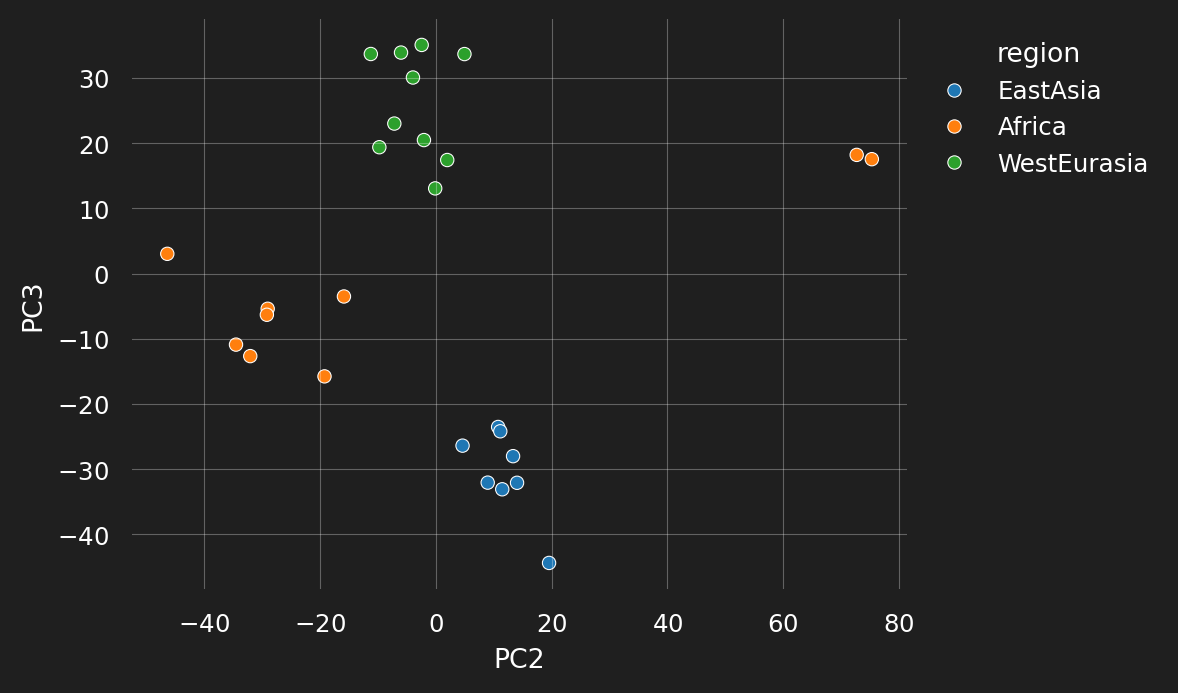

In [36]:
ax = seaborn.scatterplot(data=df_pca, x="PC2", y="PC3", hue="region", palette="tab10")
seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)

#### Try to plot PC2 and PC3. Do you see the same patterns? What is the correlation between PC2 and PC3?

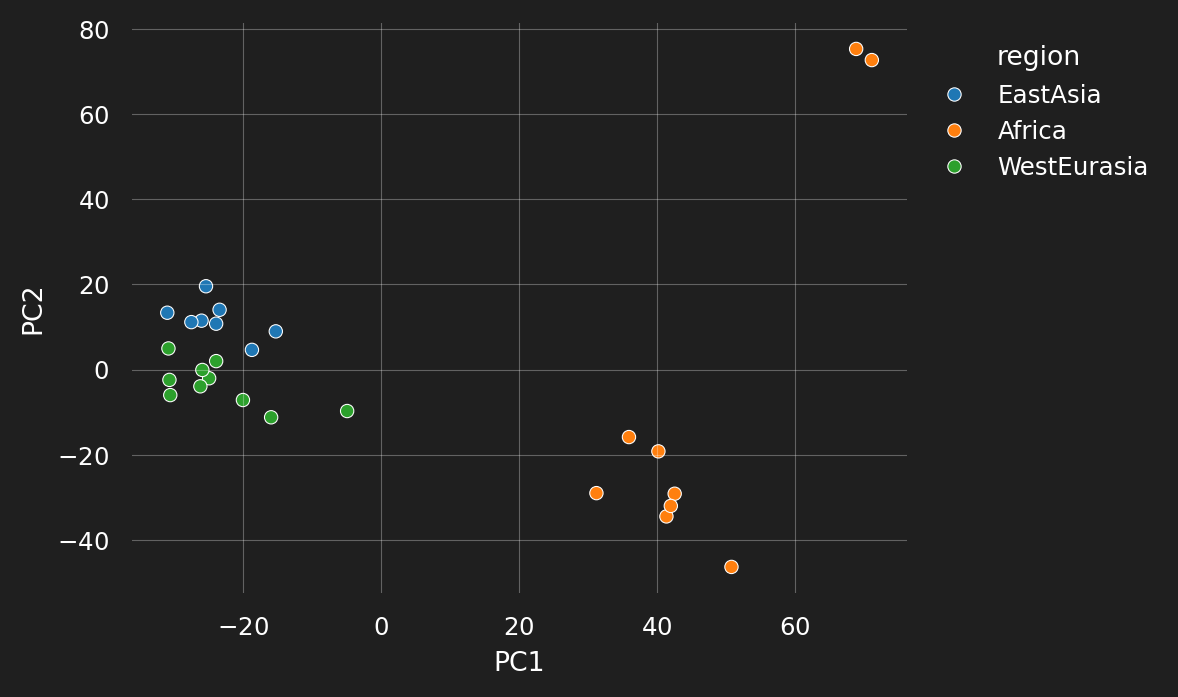

In [37]:
ax = seaborn.scatterplot(data=df_pca, x="PC1", y="PC2", hue="region", palette="tab10")
seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)

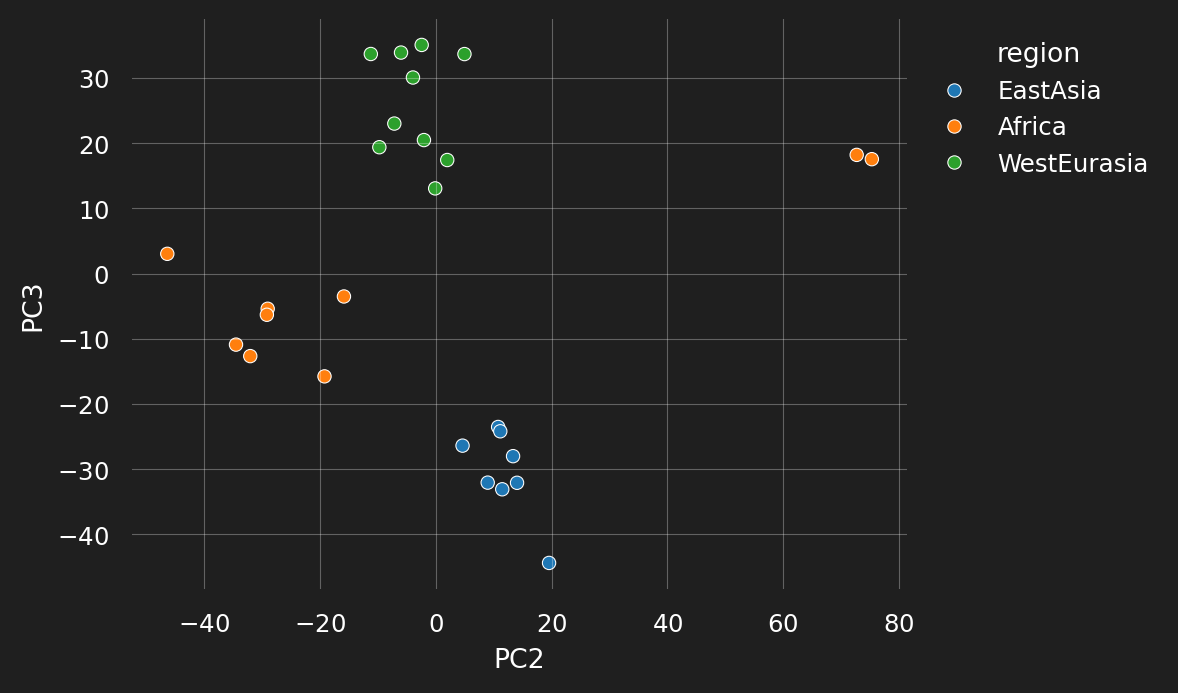

In [38]:
ax = seaborn.scatterplot(data=df_pca, x="PC2", y="PC3", hue="region", palette="tab10")
seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)

#### Try also to color the graph based on population. What do you observe?

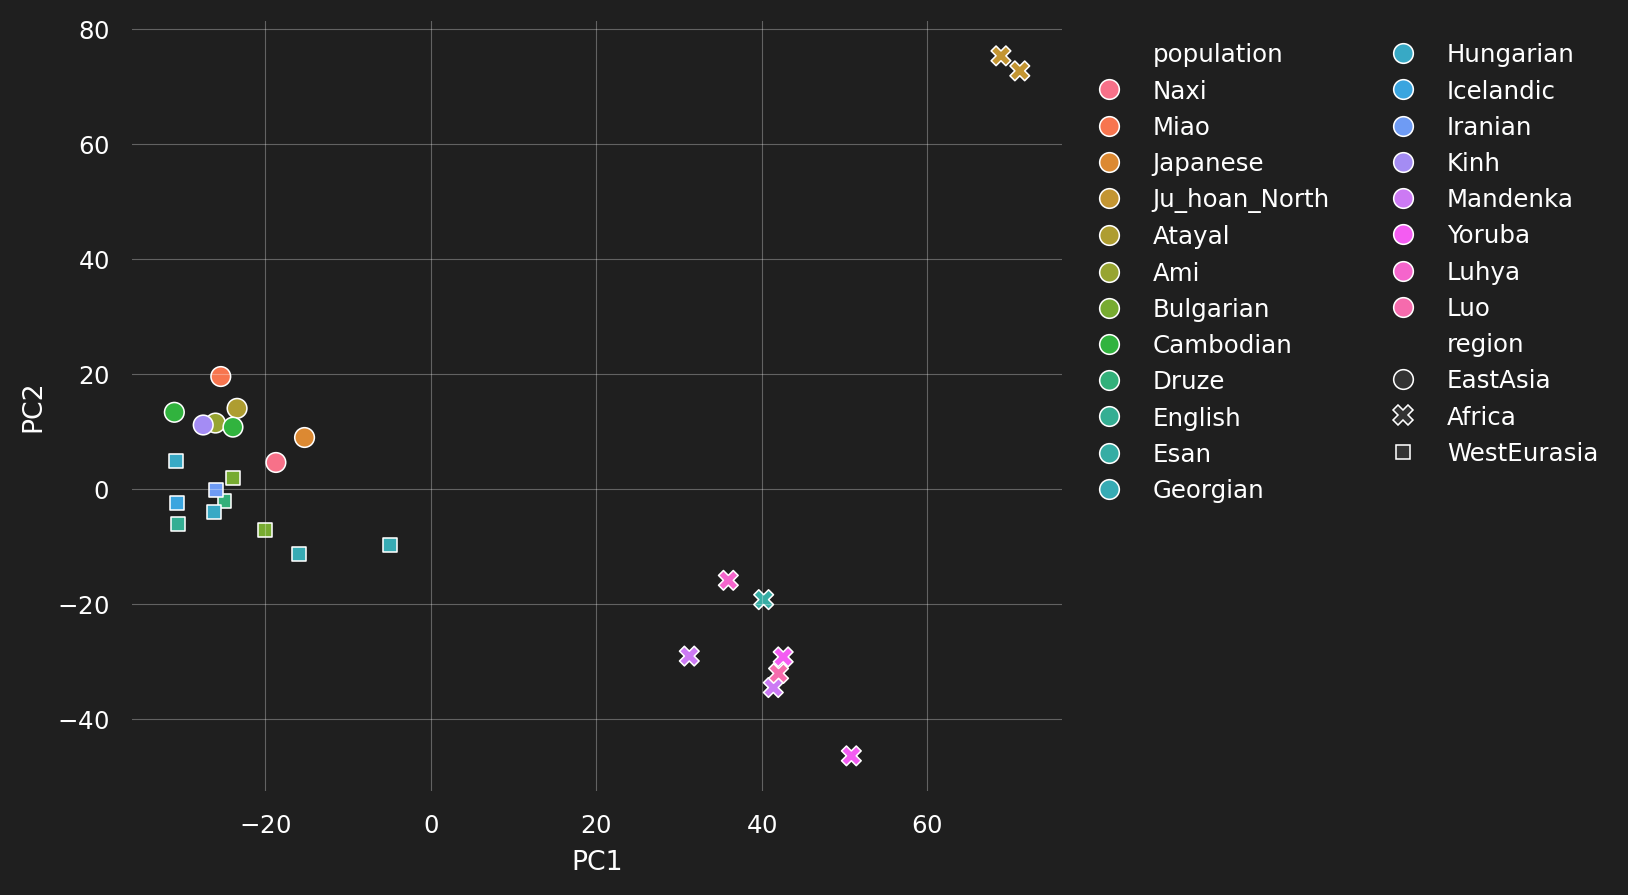

In [39]:
with vscode_theme(figsize=(6, 5)):
    ax = seaborn.scatterplot(data=df_pca, x="PC1", y="PC2", hue="population", style='region', s=50)
    seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, ncol=2)

## LD Pruning

Now we will implement LD pruning using sgkit's built-in functions. sgkit computes pairwise LD ($r^2$) within sliding windows and removes one SNP from each highly-correlated pair.

In [41]:
numpy.random.seed(1000)

# Filter the dataset to only fully-called variants
called_idx = numpy.where(is_called)[0]
ds_filt = ds.isel(variants=called_idx)

print(f"SNPs before: {ds.variants.size}")
print(f"SNPs after: {ds_filt.variants.size}")

SNPs before: 49868
SNPs after: 49468


In [43]:
ds_filt["call_dosage"] = ds_filt["call_genotype"].sum(dim="ploidy")

# Window by variant for LD computation
ds_windowed = sgkit.window_by_variant(ds_filt, size=500, step=250)

# # Compute LD matrix (Rogers-Huff r) within windows
ds_ld = sgkit.ld_matrix(ds_windowed)
#plt.matshow(ds_ld.values)

# LD prune with threshold 0.3: returns a boolean DataArray (True = keep)
ld_threshold = 0.3
ds_pruned = sgkit.ld_prune(ds_windowed, threshold=ld_threshold)

print(f"SNPs before LD pruning: {ds_filt.variants.size}")
print(f"SNPs after LD pruning (threshold={ld_threshold}): {ds_pruned.variants.size}")

SNPs before LD pruning: 49468
SNPs after LD pruning (threshold=0.3): 3851


#### Implement different LD thresholds (0.1, 0.2, 0.3, 0.4, 0.5). How many SNPs are left after each filtering threshold? Are these SNPs linked?

In [19]:
# Hint for Q.5: try different LD thresholds
# The LD matrix is already computed; only the pruning threshold changes
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5]:
    keep = sg.ld_prune(ds_windowed, threshold=threshold)
    print(f"LD threshold {threshold}: {keep.variants.size} SNPs remaining out of {ds_filt.variants.size}")

LD threshold 0.1: 2798 SNPs remaining out of 49468
LD threshold 0.2: 3243 SNPs remaining out of 49468
LD threshold 0.3: 3851 SNPs remaining out of 49468
LD threshold 0.4: 4714 SNPs remaining out of 49468
LD threshold 0.5: 6352 SNPs remaining out of 49468


#### Redo the PCA analysis on the LD-pruned data set. Does it make a difference?

## Admixture

While PCA gives us a visual summary of population structure, it does not directly tell us what proportion of each individual's genome derives from different ancestral sources. For that, we turn to model-based ancestry estimation using ADMIXTURE.

ADMIXTURE belongs to a family of model-based clustering methods for population genetics, following in the tradition of STRUCTURE (Pritchard et al. 2000). The shared idea is to posit that the observed genotypes in our sample were generated by mixing together *K* unobserved ancestral populations, each characterized by its own allele frequencies. The goal is to simultaneously infer those ancestral allele frequencies and the proportion of each individual's genome that derives from each ancestral source.

<!-- ADMIXTURE is a maximum-likelihood method that models each individual's genotype as arising from a mixture of *K* ancestral populations, each with its own set of allele frequencies. Given a value of *K*, the algorithm estimates two things simultaneously: the allele frequencies in each of the *K* ancestral populations (the *P* matrix), and the proportion of each individual's ancestry that derives from each ancestral population (the *Q* matrix). The model assumes that, conditional on these ancestry proportions and allele frequencies, genotypes at different SNPs are independent — which is why, as with PCA, it is good practice to prune for LD before running the analysis. -->

The ADMIXTURE model assumes that each individual *i* in our sample derives some fraction of their ancestry from each of *K* ancestral populations, and that genotypes at each SNP are drawn independently given these ancestry proportions and the allele frequencies of the ancestral populations.

More precisely, consider individual *i* at biallelic SNP *j*. The individual carries a diploid genotype, which we code as $g_{ij} \in \{0, 1, 2\}$ — the count of the alternative allele. The model has two sets of parameters:

- $Q$ (the ancestry proportion matrix): $q_{ik}$ is the fraction of individual *i*'s genome derived from ancestral population *k*. For each individual, these sum to one: $\sum_k q_{ik} = 1$, and all $q_{ik} \geq 0$.

- $P$ (the ancestral allele frequency matrix): $p_{kj}$ is the frequency of the alternative allele at SNP *j* in ancestral population *k$.

Under the model, each of the two allele copies carried by individual *i* at SNP *j* is drawn independently. For each copy, the model first picks an ancestral population *k* with probability $q_{ik}$, and then draws the allele from that population's allele frequency $p_{kj}$. The probability that a single allele copy is the alternative allele is therefore:

$$f_{ij} = \sum_{k=1}^{K} q_{ik} \, p_{kj}$$

Since the genotype $g_{ij}$ is the sum of two independent Bernoulli draws, it follows a binomial distribution:

$$P(g_{ij} \mid Q, P) = \binom{2}{g_{ij}} f_{ij}^{g_{ij}} (1 - f_{ij})^{2 - g_{ij}}$$

Assuming independence across SNPs (conditional on $Q$ and $P$), the full log-likelihood for all individuals and all SNPs is:

$$\mathcal{L}(Q, P) = \sum_i \sum_j \left[ g_{ij} \log f_{ij} + (2 - g_{ij}) \log(1 - f_{ij}) \right]$$

(ignoring the constant binomial coefficient term, which does not depend on the parameters). The task of inference is to find the values of $Q$ and $P$ that maximize this log-likelihood, subject to the constraints that $q_{ik} \geq 0$, $\sum_k q_{ik} = 1$, and $0 \leq p_{kj} \leq 1$.

Maximizing the log-likelihood over $Q$ and $P$ jointly is a non-convex optimization problem — there is no closed-form solution and many local optima. ADMIXTURE uses a *block relaxation* algorithm, which alternates between optimizing $Q$ with $P$ held fixed and optimizing $P$ with $Q$ held fixed. Each of these sub-problems is a constrained optimization that ADMIXTURE solves efficiently using sequential quadratic programming.

The algorithm proceeds as follows:

1. Initialize $Q$ and $P$ with random values (respecting the constraints).
2. Fix $P$ and update each row of $Q$ (i.e., the ancestry proportions for each individual) to maximize the log-likelihood.
3. Fix $Q$ and update each column of $P$ (i.e., the allele frequencies for each SNP in each ancestral population) to maximize the log-likelihood.
4. Repeat steps 2–3 until the log-likelihood increases by less than a convergence threshold (by default, $\varepsilon = 10^{-4}$) between iterations.

To speed up convergence, ADMIXTURE uses a quasi-Newton acceleration method that takes advantage of the curvature of the likelihood surface. This makes convergence substantially faster than the simple EM algorithm used by the related program FRAPPE.

Because the optimization landscape has multiple local optima, different random initializations can lead to different solutions. In practice, it is wise to run ADMIXTURE multiple times with different random seeds (using the `-s` flag) and compare the results. Solutions with higher log-likelihood values are preferred, and consistent patterns across runs provide confidence that the results reflect genuine structure rather than artifacts of the optimization.


Before we can run ADMIXTURE, we need to convert the pruned dataset to PLINK binary format (.bed, .bim, .fam):

In [45]:
prefix = "chr2_135_145_flt_pruned.gds"
contig_names = ds_pruned.attrs.get("contigs", ["2"])
variant_contig_idx = ds_pruned.variant_contig.values
variant_pos = ds_pruned.variant_position.values

# Write .fam file (one line per individual)
with open(f"{prefix}.fam", "w") as f:
    for s in samples:
        # FID IID father mother sex phenotype
        f.write(f"{s} {s} 0 0 0 -9\n")

# Write .bim file (one line per SNP)
with open(f"{prefix}.bim", "w") as f:
    for i in range(ds_pruned.variants.size):
        chrom = contig_names[variant_contig_idx[i]] if contig_names else "2"
        f.write(f"{chrom} snp{i} 0 {variant_pos[i]} A G\n")

# Write .bed file (PLINK binary genotype format, SNP-major)
n_samples = len(samples)
n_snps = ds_pruned.variants.size
bytes_per_snp = (n_samples + 3) // 4  # 4 genotypes per byte

genotypes = ds_pruned['call_genotype'].values

with open(f"{prefix}.bed", "wb") as f:
    # Magic number and mode byte (SNP-major)
    f.write(bytes([0x6C, 0x1B, 0x01]))
    for snp_i in range(n_snps):
        snp_bytes = bytearray(bytes_per_snp)
        for sample_j in range(n_samples):
            g = genotypes[snp_i, sample_j].sum()
            # PLINK encoding: 00=hom_ref(0), 01=missing, 10=het(1), 11=hom_alt(2)
            if g == 0:
                code = 0b00
            elif g == 1:
                code = 0b10
            elif g == 2:
                code = 0b11
            else:
                code = 0b01  # missing
            byte_idx = sample_j // 4
            bit_offset = (sample_j % 4) * 2
            snp_bytes[byte_idx] |= (code << bit_offset)
        f.write(snp_bytes)

print(f"Written PLINK files: {prefix}.bed, {prefix}.bim, {prefix}.fam")
print(f"  {n_snps} SNPs, {n_samples} samples")


Written PLINK files: chr2_135_145_flt_pruned.gds.bed, chr2_135_145_flt_pruned.gds.bim, chr2_135_145_flt_pruned.gds.fam
  3851 SNPs, 27 samples


Running ADMIXTURE is straightforward. Given a PLINK binary file, you specify the number of ancestral populations *K* on the command line:

In [46]:
# ! srun --mem-per-cpu=5g --time=3:00:00 --account=populationgenomics \
#     admixture chr2_135_145_flt_pruned.gds.bed 3

In [47]:
%%bash
admixture chr2_135_145_flt_pruned.gds.bed 3

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 27x3851
Performing five EM steps to prime main algorithm


1 (EM) 	Elapsed: 0.004	Loglikelihood: -46266.1	(delta): 118440
2 (EM) 	Elapsed: 0.004	Loglikelihood: -43153.3	(delta): 3112.84
3 (EM) 	Elapsed: 0.004	Loglikelihood: -42397.3	(delta): 755.95
4 (EM) 	Elapsed: 0.004	Loglikelihood: -41931.9	(delta): 465.448
5 (EM) 	Elapsed: 0.004	Loglikelihood: -41611.2	(delta): 320.691
Initial loglikelihood: -41611.2
Starting main algorithm
1 (QN/Block) 	Elapsed: 0.028	Loglikelihood: -38993.8	(delta): 2617.35
2 (QN/Block) 	Elapsed: 0.023	Loglikelihood: -37679.8	(delta): 1314.05
3 (QN/Block) 	Elapsed: 0.025	Loglikelihood: -37305.3	(delta): 374.498
4 (QN/Block) 	Elapsed: 0.023	Loglikelihood: -37164.8	(delta): 140.465
5 (QN/Block) 	Elapsed: 0.024	Loglikelihood: -37082.5	(delta): 82.2782
6 (QN/Block) 	Elapsed: 0.028	Loglikelihood: -37072.1	(delta): 10.4182
7 (QN/Block) 	Elapsed: 0.028	Loglikelihood: -37072.1	(delta): 0.0533539
8 (QN/Block) 	Elapsed: 0.027	Loglikelihood: -37072.1	(delta): 2.4325e-07
Summary: 
Converged in 8 iterations (0.249 sec)
Loglikelihood

#### Have a look at the Fst across populations, that is printed. Would you guess which populations are Pop0, Pop1 and Pop2 referring to?


Admixture produced two output files: `chr2_135_145_flt_pruned.gds.3.Q` containing the ancestry proportions (one row per individual, one column per ancestral component), and `chr2_135_145_flt_pruned.gds.3.P` containing the estimated allele frequencies. The results are typically visualized as a stacked bar chart where each individual is a vertical bar divided into *K* colored segments, with the height of each segment representing the estimated ancestry proportion.




An important question in ADMIXTURE analysis is how many ancestral populations should we assume. The model does not estimate *K* — you have to supply it. Choosing too few components will fail to capture real structure, while choosing too many will overfit: the model will start fitting noise and idiosyncrasies of the particular sample rather than genuine population-level patterns.

ADMIXTURE addresses this through *cross-validation* (CV), a general statistical technique for assessing how well a model generalizes to data it has not seen. The logic is simple: a model that fits real structure will predict held-out data well, while an overfitted model will predict held-out data poorly despite fitting the training data well.

ADMIXTURE's cross-validation procedure works as follows:

1. Partition all observed genotypes (not individuals, but individual genotype entries $g_{ij}$) into *v* roughly equally-sized *folds* (by default, $v = 5$).

2. For each fold in turn, mask (set to missing) all genotypes in that fold.

3. Fit the model (estimate $Q$ and $P$) using only the remaining unmasked genotypes.

4. Use the estimated parameters to predict the masked genotypes. The predicted genotype for individual *i* at SNP *j* is the expected value under the fitted model:

$$\hat{\mu}_{ij} = 2 \sum_k \tilde{q}_{ik} \, \tilde{p}_{kj}$$

where $\tilde{Q}$ and $\tilde{P}$ are the parameter estimates from the training set (the data with that fold masked).

5. Compute the *prediction error* for each masked genotype by comparing the predicted value $\hat{\mu}_{ij}$ to the actual genotype $g_{ij}$.

The prediction error is measured using the *deviance residual* for the binomial model:

$$d(g_{ij}, \hat{\mu}_{ij}) = g_{ij} \log\!\left(\frac{g_{ij}}{\hat{\mu}_{ij}}\right) + (2 - g_{ij}) \log\!\left(\frac{2 - g_{ij}}{2 - \hat{\mu}_{ij}}\right)$$

This is a natural measure of discrepancy for count data bounded between 0 and 2. It is zero when the prediction exactly matches the observation and increases as the prediction deviates. The *cross-validation error* is the average of these deviance residuals across all masked genotypes over all folds.

This entire procedure is repeated for each candidate value of *K*. The CV error for each *K* can then be compared: the value of *K* that minimizes the cross-validation error is the one whose fitted model best predicts genotypes that were not used in fitting. A model with too few components will underfit and predict poorly (high CV error), while a model with too many components will overfit and also predict poorly because parameter estimates become noisy when the model is more complex than the data can support.

In practice, you run the cross-validation by adding the `--cv` flag:

In [48]:
%%bash
for K in 1 2 3 4 5; do
    admixture --cv chr2_135_145_flt_pruned.gds.bed $K | tee log${K}.out
done

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 27x3851
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 0.001	Loglikelihood: -43809.9	(delta): 170338
2 (EM) 	Elapsed: 0.001	Loglikelihood: -43809.9	(delta): 

CV error (K=1): 0.43306
Writing output files.
****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 27x3851
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 0.002	Loglikelihood: -45896	(delta): 131962
2 (EM) 	Elap

Plotting these values as a function of *K* usually reveals a curve that decreases as *K* increases from 1 (capturing more real structure), reaches a minimum (the best predictive model), and then increases again (overfitting). However, the curve is often fairly flat around the minimum, meaning that several values of *K* have similar predictive performance. In such cases, there is no single "correct" *K*, and it is informative to examine and compare the ADMIXTURE results across multiple values of *K*.

In [49]:
%%bash
grep -h CV log*.out
grep -h CV log*.out > CV_logs.txt

CV error (K=1): 0.43306
CV error (K=2): 0.44580
CV error (K=3): 0.48011
CV error (K=4): 0.54877
CV error (K=5): 0.59852


Look at the distribution of CV error:

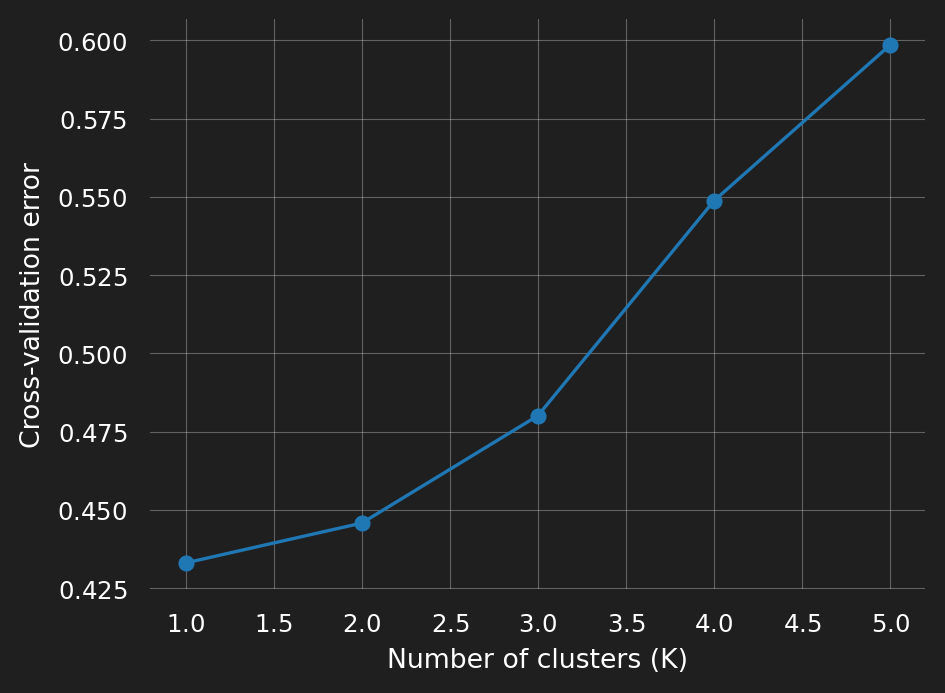

In [ ]:
ks, cv_errors = [], []
with open("CV_logs.txt") as f:
    for line in f:
        m = re.search(r"K=(\d+)\):\s+([\d.]+)", line)
        if m:
            ks.append(int(m.group(1)))
            cv_errors.append(float(m.group(2)))
plt.plot(ks, cv_errors, "o-")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Cross-validation error")
plt.show()

#### What is the cross-validation error? Based on this graph, what is the best K?

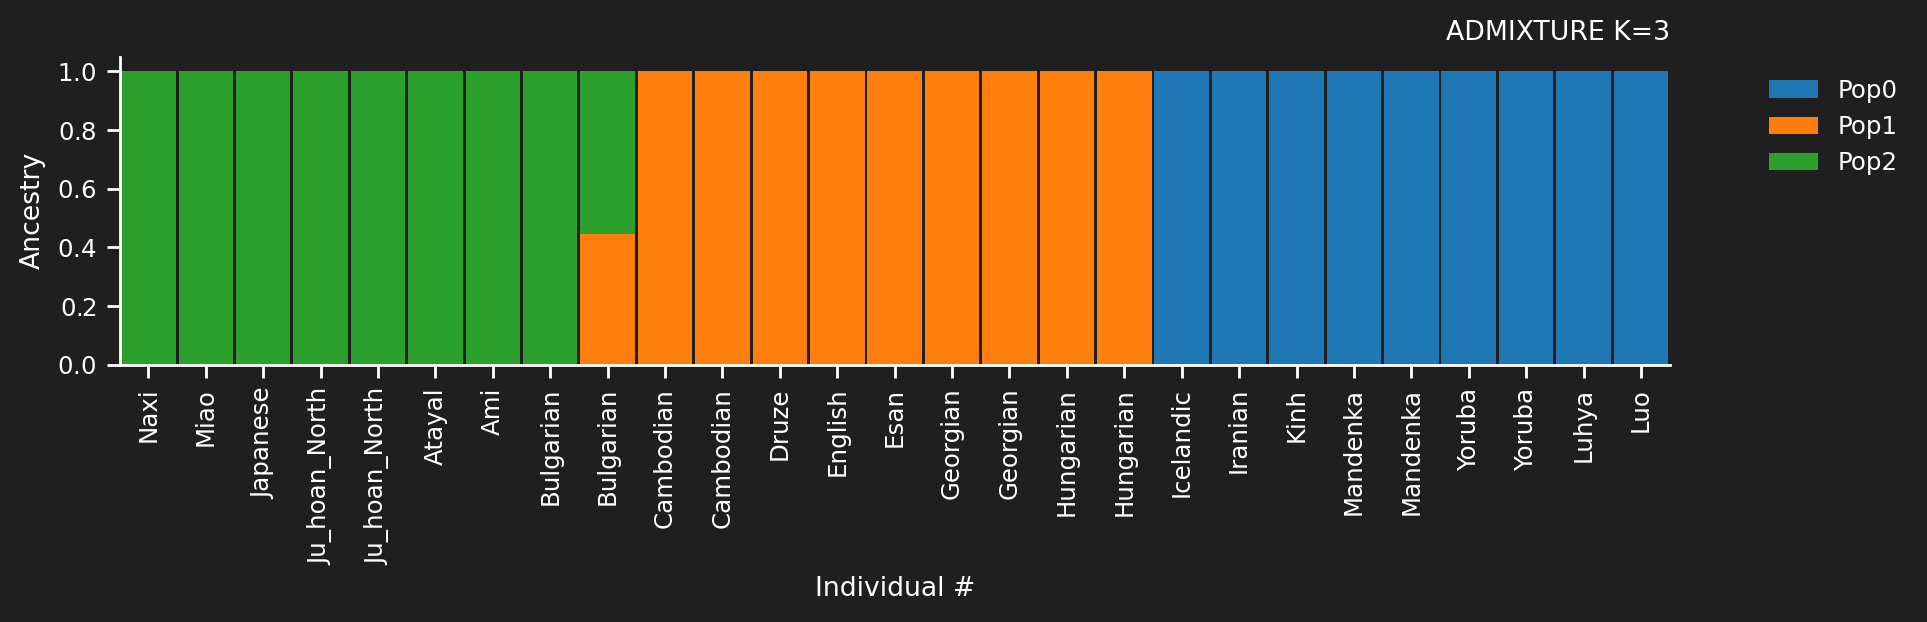

<Figure size 500x370 with 0 Axes>

In [54]:
# Plot the Q estimates for K=3
Q = pandas.read_csv("chr2_135_145_flt_pruned.gds.3.Q", sep="\s+", header=None)
Q.columns = [f"Pop{i}" for i in range(Q.shape[1])]

# Sort individuals by ancestry proportions
Q_sorted = Q.sort_values(by=list(Q.columns)).reset_index(drop=True)


with vscode_theme(style='ticks', figsize=(10, 2)):

    bottom = numpy.zeros(len(Q_sorted))
    # colors_admix = plt.cm.rainbow(np.linspace(0, 1, Q.shape[1]))
    colors_admix = plt.cm.tab10.colors[:Q.shape[1]]

    for i, col in enumerate(Q_sorted.columns):
        plt.bar(range(len(Q_sorted)), Q_sorted[col], bottom=bottom,
            color=colors_admix[i], width=0.95, edgecolor="none", label=col)
        bottom += Q_sorted[col].values

    plt.xlabel("Individual #")
    plt.ylabel("Ancestry")
    plt.title("ADMIXTURE K=3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xlim(-0.5, len(Q_sorted) - 0.5)
    # pops = info.population.values
    pops = df_pca.population
    plt.xticks(list(range(len(pops))), pops, rotation=90) 
    plt.show()

When interpreting ADMIXTURE results, keep in mind that the ancestral components do not necessarily correspond to real historical populations — they are statistical constructs that summarize the major axes of allele-frequency variation in the sample. The labeling of components is arbitrary: which color corresponds to "African ancestry" depends on how the components happen to align with the sampled populations. With our data set, we expect that at *K* = 3, the three components will roughly correspond to African, East Asian, and West Eurasian ancestry. At higher values of *K*, the model will begin to distinguish finer-scale structure, for example separating the Ju/'hoan (a Khoisan-speaking population) from the other African groups, or resolving structure within East Asia.

It is also worth noting that the model is purely statistical and does not incorporate any geographic, linguistic, or historical information. Two populations that appear similar in an ADMIXTURE plot share similar allele frequencies, but this could reflect shared recent ancestry, ancient shared ancestry, gene flow, or simply convergent allele frequencies due to drift in small populations. Complementary analyses — such as PCA, $F_{ST}$ calculations, $f$-statistics, and demographic modeling — are needed to distinguish among these scenarios.

<!-- ## Assignment

In the following part of this exercise you will do both analyses (PCA and Admixture) using a different dataset. The data comes from the HAPMAP Consortium, to learn more about the populations studied in this project access [here](http://www.sanger.ac.uk/resources/downloads/human/hapmap3.html).

The VCF file **hapmap.vcf**, an information file **relationships_w_pops_121708.txt**, as well as **.bim**, **.bed**, **.fam** files (only to be used if you get stuck during the exercise) are available for the admixture analysis, this dataset is placed in the cluster:

```
~/populationgenomics/data/assignment
```

Answer the same questions as answered in this tutorial and write a report (5 pages maximum) about the results and the analysis you have done. -->